# Intro

We've all been asked the question "What type of music do you listen to?".  Are in the "a little bit of everything" camp, or do you feel you have more specific tastes.   The analysis below is a quantitative approach to answering this question.  Leveraging data - [xx] features for songs in my library - sourced from Spotify, I will see if there are distinct clusters in the music I frequently listen to that represent different types of music.

While this is fun to dig into on a personal level, there are parallels with how this can be applied to a business perspective as well.  For example, Spotify could identify ...

# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------

In [1]:
########################################## IMPORT LIBRARIES ##########################################
import pandas as pd
import numpy as np 
import time 
import itertools

import sys
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import ks_2samp

from yellowbrick.cluster import KElbowVisualizer

########################################## MISC SETTINGS ##########################################
## Always show all columns in dataframe
pd.set_option('display.max_columns', None)

########################################## SPOTIFY CREDENTIALS ##########################################
## Authentication info
CLIENT_ID = '58bf70b350d04276a69418b8d7dc0cb1'
CLIENT_SECRET = '42d7b4033b22494185af1cc33a069bcd'

## API Login
client_credentials_manager = SpotifyClientCredentials(client_id = CLIENT_ID, client_secret = CLIENT_SECRET)

## Spotify object to access API
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 

########################################## RUNTIME FUNCTION ##########################################
def runtime(start):
    print('Runtime: ' + str(np.round((time.time() - start)/60, 1)) + ' minutes')

# Custom Functions

In [2]:
def show_playlists(username, playlist_string):
    
    """
    Show all playlists and corresponding playlist IDs for a given Spotify username.  
    List can be subset by entering all or a portion of the playlist title for 'playlist_string'
    
    """
    
    playlist_info =  sp.user_playlists(user = str(username))
    
    for i in np.arange(len(playlist_info['items'])):
        
        if playlist_string in playlist_info['items'][i]['name']:
        
            print(playlist_info['items'][i]['name'], ':  ', playlist_info['items'][i]['id'])
        

In [3]:
def create_playlist_df(playlist_id):
    
    """
    Create a dataframe containing the audio features of the songs in a given playlist.
    """
    
    ## Get tracks from the given playlist (dictionary of tracks and corresponding track info)
    tracks = sp.user_playlist_tracks(user = 'spotify', playlist_id = playlist_id)
    
    ## Create list of the URIs for each track
    tracks_uri_list = [x['track']['uri'] for x in tracks['items']]
    
    
    ## Extract track features from the dictionary
    features = []
    for i in tracks_uri_list:
        features = features + sp.audio_features(i)

    ## Add song and artist name to track dictionaries
    for i in np.arange(len(features)):
        ## Song name
        features[i]['Song Title'] = tracks['items'][i]['track']['name']

        ## Main Artist name
        features[i]['Main Artist'] = tracks['items'][i]['track']['artists'][0]['name']
        
        
    ## Create feature dataframe
#     cols_to_drop = ['analysis_url',  'track_href', 'uri',  'duration_ms', 'type', 'mode', 'time_signature']
    cols_to_drop = ['analysis_url',  'track_href', 'uri',  'type', 'mode', 'duration_ms', 'time_signature', 'key']

    features_df = pd.DataFrame(features).drop(cols_to_drop, axis=1)

    ## Rearrange order of columns
    column_order = ['id', 'Song Title', 'Main Artist', 'danceability', 'tempo', 'energy', 'speechiness','loudness',
                    'liveness', 'acousticness', 'instrumentalness', 'valence']
    
    return features_df.reindex(columns = column_order)
#     return features_df

In [4]:
def cluster_distrib(df, cluster_col):
    
    '''
    Returns a breakdown of the distribution of songs per cluster, speficially the number of songs in each cluster,
    and the % of the overall song count.
    '''
    
    df_clusters = pd.DataFrame(df.groupby(cluster_col)['id'].nunique())
    
    df_clusters['%'] = df_clusters['id'] / df_clusters['id'].sum()
    df_clusters.columns = ['Song Count', '%']
    
    return df_clusters

In [5]:
# def ks_test_results(df, feature):
    
#     """
#     Run Kolmogorov-Smirnov (KS) Test on all combinations of clusters for a given feature.  Populate results into a dataframe.
#     P-values <= 0.05 will be formated in green color, representing difference for this feature is statistically significant
    
#     df: main dataframe, containing feature data & cluster assignments
#     feature: name of feature to compare between distributions
#     """
    
#     ## Create a list of all possible combinations of cluster names to compare (wihtout repetition)
#     combo_list = list(itertools.combinations(df['Cluster'].unique(), r = 2))

#     ## Create shell of dataframe to hold results
#     df_results = pd.DataFrame(index = combo_list, columns = ['Statistic', 'P-Value'])


#     ## for each possible combination of clusters to compare
#     for combo in combo_list:

#         ## Run KS Test; store results to be input into dataframe
#         ks_result = ks_2samp(df[df['Cluster'] == combo[0]][feature], df_final[df_final['Cluster'] == combo[1]][feature])

#         ## populate row corresponding with given combo with the given results
#         df_results.loc[df_results.index == combo, 'Statistic'] = ks_result[0]
#         df_results.loc[df_results.index == combo, 'P-Value'] = ks_result[1]

    
#     ## Define function to identify p-values < 0.05
#     def highlight_pval(value):
#         color = 'green' if value <= 0.05 else 'black'
#         return 'color: {}'.format(color)

    
#     print(feature.upper())
#     return df_results.style.applymap(highlight_pval)    


___
___
# <font color = green>  Extracting & Prepping the Data

### Create dataframe with features of my saved songs
The Spotipy package only allows pulling 100 songs per playlist.  I created a playlist for each 100 songs; each will be made into seperate dataframes, then combined into one.

- Guide to song features:
 https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

In [6]:
show_playlists('mvashaw11', 'My Songs')

My Songs - Misc :   4XSkApbNR0M6dsRtV21e9t
My Songs - 4 :   5gB8kMWwGSWK6OGdf3hqvG
My Songs - 3 :   5HNZLCd0nvlFOFbJi7xfEJ
My Songs - 2 :   7HSciQHgm8ZzibaVwLwxOH
My Songs - 1 :   7hHtw5oZaF7KXSbw8Uaxlv


Create a dataframe containing all of the music data

In [7]:
start_time = time.time()

## Create dataframes for each sub-playlist
df_savedsongs_1 = create_playlist_df('7hHtw5oZaF7KXSbw8Uaxlv')
df_savedsongs_2 = create_playlist_df('7HSciQHgm8ZzibaVwLwxOH')
df_savedsongs_3 = create_playlist_df('5HNZLCd0nvlFOFbJi7xfEJ')
df_savedsongs_4 = create_playlist_df('5gB8kMWwGSWK6OGdf3hqvG')
df_savedsongs_5 = create_playlist_df('4XSkApbNR0M6dsRtV21e9t')

## Combine the individual playlists into one
df_mysongs = pd.concat([df_savedsongs_1, df_savedsongs_2, df_savedsongs_3,
                        df_savedsongs_4, df_savedsongs_5], ignore_index = True)

## Drop duplicates in case any songs are in multiple playlists
df_mysongs.drop_duplicates(inplace = True)

## Show code run-time
runtime(start_time)

## Print size of dataframe
print(df_mysongs.shape)

df_mysongs.head()

Runtime: 0.7 minutes
(355, 12)


,id,Song Title,Main Artist,danceability,tempo,energy,speechiness,loudness,liveness,acousticness,instrumentalness,valence
0,5iUQMwxUPdJBFeGkePtM66,Dang! (feat. Anderson .Paak),Mac Miller,0.836,107.018,0.670,0.2300,-6.907,0.0837,0.00826,0.000355,0.556
1,0hNduWmlWmEmuwEFcYvRu1,Sunset Lover,Petit Biscuit,0.783,90.838,0.467,0.0503,-9.474,0.1090,0.72900,0.809000,0.236
2,2lrRWbiHPdBicufAqrGN3r,Don't Wanna Fight,Alabama Shakes,0.606,100.433,0.915,0.1660,-3.292,0.1050,0.25900,0.107000,0.551
3,1AlcpxsgzYwAJ1SfMPPWU4,Redbone,Childish Gambino,0.743,160.070,0.372,0.1320,-10.459,0.1200,0.19400,0.014000,0.575
4,7y6c07pgjZvtHI9kuMVqk1,Get It Together,Drake,0.781,123.011,0.721,0.0514,-9.133,0.1040,0.09450,0.391000,0.849


___
___
# <font color = green> Exploratory Data Analysis
    
Before digging into any analysis, it is good practice to get to know the data being worked with first.  Let's look at some summary info to see if there are any initial takeaways

**Distribution of Artists** (Top 10):  Are there any artists with more songs than others in my music collection?

[Text(0, 0, '24'),
 Text(0, 0, '20'),
 Text(0, 0, '18'),
 Text(0, 0, '15'),
 Text(0, 0, '12'),
 Text(0, 0, '8'),
 Text(0, 0, '7'),
 Text(0, 0, '7'),
 Text(0, 0, '7'),
 Text(0, 0, '6')]

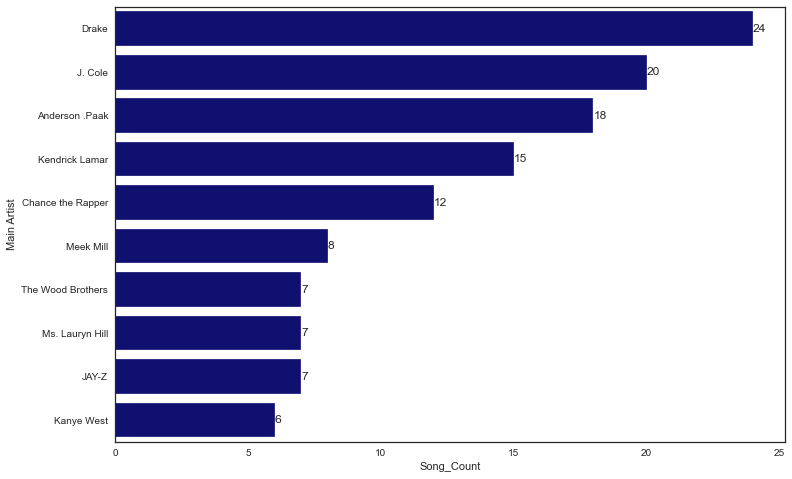

In [8]:
df_artist_count = df_mysongs.groupby('Main Artist').agg(Song_Count = ('id','nunique'))

## Sort in descending order
df_artist_count.sort_values('Song_Count', ascending = False, inplace = True)

## Set size of plot
plt.figure(figsize = (12, 8))
sns.set_style('white')

## Select the 
top_n = 10

ax = sns.barplot(x = df_artist_count['Song_Count'][:top_n], y =  df_artist_count.index[:top_n], color = 'navy')

ax.bar_label(ax.containers[0])

2) **Distribution of Audio Features:**  Let's take a look at what does my collection look like at an aggregate level, measured by the features in the Spotify data.  Below is a summary of what the features mean:



- **Danceability**: Based on combination of musical elements like tempo, rhythm stability, beat strength, and regularity.


- **Energy**: Perceptual measure of *instensity & activity*; based on dynamic range, perceived loudness, timbre, onset rate, entropy.
    - higher energy = fast, loud, noisy


- **Speechiness**: Presence of spoken words in the track.  
    - '< 0.33      = likely music & non-speech tracks
    - 0.33 - 0.66 = contain both music & speech
    - '> 0.66      = track is probably entirely spoken word


- **Acousticness**: Measure of confidence if track is acoustic (1 = confident track is acoustic).



- **Instrumentalness**:  Greater than .5 represents mostly instrumental tracks.
    - "ooh", "aah" sounds treated as instrumental; rap & spoken word treated as vocal


- **Loudness**: Loudness in decibels, averaged across a given track


- **Tempo**: beats per minute.  Speed or pace of the song.


- **Valence**:  Measure of positiveness in the track. Higher valence represents more happy and cheerful song, low valence represents more negative mood.


- **Liveness**:  Measure of liklihood track was performed live, based on detection of audience in the recording.
    - Above 0.8 = strong liklihood track is live 


- **Key**: represents pitch; higher the value = higher the pitch.


- <font color = grey> **Time Signature**:  Measure of how many beats are in each bar.





<font color = grey> Reference:  https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features

array([[<AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'energy'}>],
       [<AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'liveness'}>],
       [<AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'valence'}>]], dtype=object)

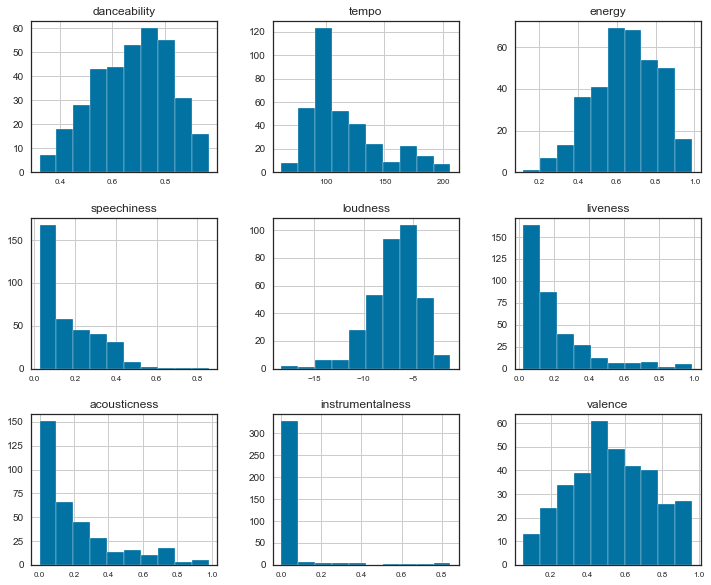

In [9]:
feature_data = df_mysongs.drop(['Main Artist', 'Song Title', 'id'], axis = 1)
feature_data.hist(xlabelsize=8, figsize=(12,10))

### Initial insights:

On an aggregate level, my music collection can be generalized as:

- Louder, higher energy, and danceable.
- Low amounts of instrumental or acoustic/live music.  
- Lower tempo music.
- Relatively even distribution of the "mood" (positive/negative) of the songs, with slight skew towards positive.
- Not much variance in song length.
- Almost entirely 4 beats per bar


___
___
# <font color = green> Clustering
    
Now that we have a view of what my music collection looks like on the whole, let's do a deeper dive to see if there are distinguishable clusters in the collection.  In other words, are there groupings of songs that are very similar within a given group, but with distinct differences compared to other parts of my music collection.
    
If we see that these distinct clusters or groupings do exist - that the songs can be organized into groups with each exhibiting noticably different characterisitcs - then it can be concluded that I have a varied tastes in music.  If, on the other hand, the clusters are not very different from each other, then I tend to listen to a more narrow variety of music.
    

### (1) Normalize the features

The first step is to ensure the data is in the appropriate format for the clustering analysis. Clustering utilizes distance measures, which requires all features to be on the same scale; if any feature(s) have a larger magnitude than the others - for example numbers in the thousands vs decimals -  it can significantly distort the distance metrics. Therefore, all the features need to be adjusted to the same scale. 

As seen below, many features range from 0-1, while others are in the hundreds or thousands. This would severly skew the distance metrics used in k-means clustering.

In [10]:
## Remove non-numeric info (descriptive info) from song dataframe
df_mysongs_features = pd.DataFrame(df_mysongs.drop(['Main Artist', 'Song Title', 'id'], axis = 1))

df_mysongs_features.index = df_mysongs['id']

df_mysongs_features.describe()

,danceability,tempo,energy,speechiness,loudness,liveness,acousticness,instrumentalness,valence
count,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000
mean,0.678321,114.598335,0.648896,0.171555,-6.863146,0.202214,0.216588,0.029654,0.529003
std,0.143195,30.171332,0.168038,0.138276,2.606972,0.181920,0.230798,0.120972,0.224158
min,0.323000,62.507000,0.118000,0.026000,-18.373000,0.021500,0.000056,0.000000,0.051900
25%,0.571000,94.799000,0.530500,0.058500,-8.254000,0.094600,0.039300,0.000000,0.367500
50%,0.693000,104.885000,0.653000,0.122000,-6.566000,0.128000,0.128000,0.000005,0.514000
75%,0.785000,127.870500,0.777000,0.269000,-5.037500,0.242000,0.305500,0.000385,0.706500
max,0.966000,205.981000,0.989000,0.855000,-1.149000,0.989000,0.981000,0.844000,0.963000


Therefore, I will scale the numeric data to account for these differences.

In [11]:
scaler = StandardScaler()

df_scaled_features = pd.DataFrame(scaler.fit_transform(df_mysongs_features), 
                                  columns = df_mysongs_features.columns, 
                                  index = df_mysongs_features.index)

df_scaled_features.describe()

,danceability,tempo,energy,speechiness,loudness,liveness,acousticness,instrumentalness,valence
count,3.550000e+02,3.550000e+02,3.550000e+02,3.550000e+02,3.550000e+02,3.550000e+02,3.550000e+02,3.550000e+02,3.550000e+02
mean,3.505803e-16,7.552644e-16,2.439363e-16,-5.254013e-17,2.451873e-16,7.873201e-17,9.382166e-17,2.001529e-17,3.208701e-16
std,1.001411e+00,1.001411e+00,1.001411e+00,1.001411e+00,1.001411e+00,1.001411e+00,1.001411e+00,1.001411e+00,1.001411e+00
min,-2.484877e+00,-1.728954e+00,-3.163834e+00,-1.054129e+00,-4.421259e+00,-9.947693e-01,-9.395090e-01,-2.454781e-01,-2.131422e+00
25%,-7.505317e-01,-6.571563e-01,-7.055709e-01,-8.187595e-01,-5.342661e-01,-5.923775e-01,-7.692343e-01,-2.454781e-01,-7.215020e-01
50%,1.026542e-01,-3.223936e-01,2.445883e-02,-3.588837e-01,1.141423e-01,-4.085214e-01,-3.843734e-01,-2.454401e-01,-6.702399e-02
75%,7.460402e-01,4.405141e-01,7.634277e-01,7.057107e-01,7.012823e-01,2.190117e-01,3.857823e-01,-2.422910e-01,7.929557e-01
max,2.011832e+00,3.033066e+00,2.026826e+00,4.949604e+00,2.194965e+00,4.331004e+00,3.316713e+00,6.741171e+00,1.938851e+00


### (2) Determine Cluster size

In [12]:
# ## Set size of plot
# plt.figure(figsize = (12, 8))
# sns.set_style('white')


# ## Declare MIN number of clusters to test
# min_k = 2

# ## Declare MAX number of clusters to test
# max_k = 10

# ## Determining the cluster size
# score_list = []
# for i in np.arange(min_k, max_k+1):
#     ## Fit a clustering model to the scaled data.  Iterate through various number of clusters
#     kmeans_model = KMeans(n_clusters=i, random_state=21).fit(df_scaled_features)
    
#     ## Create predictions using model
#     preds = kmeans_model.predict(df_scaled_features)
    
#     ## Add model k's score to list
#     score_list.append(kmeans_model.inertia_)

# ## Plot the results
# sns.lineplot(np.arange(min_k, max_k + 1), score_list)
# plt.xlabel('Number of Clusters', size = 10)

The next step is to determine the number of clusters that results in the highest amount of *similarity within* each cluster & the highest of *difference across* the various clusters.  I am leveraging the Yellowbrick package to identify that optimal number.  Additional info on this package below:

<font color = grey> The KElbowVisualizer implements the “elbow” method to help select the optimal number of clusters by fitting the clustering model with a range of values for K (the number of clusters). If the line chart resembles an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point. In the visual, the “elbow” will be indicated with a dashed line.

<font color = grey> Distortion - this method uses distortion as the scoring metric.  Distortion "computes the sum of squared distances from each point to its assigned center"

<font color = grey>  References:
- https://medium.com/data-science-community-srm/machine-learning-visualizations-with-yellowbrick-3c533955b1b3
- https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

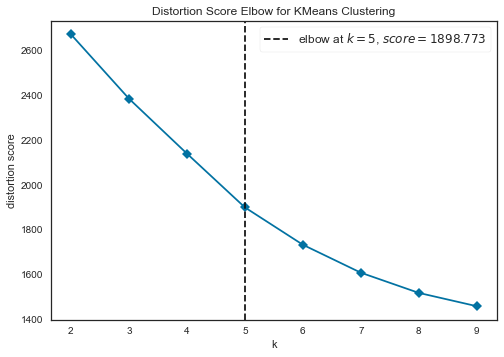

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
## Declare MIN number of clusters to test
min_k = 2

## Declare MAX number of clusters to test
max_k = 10

## Instantiate the clustering model and visualizer
model = KMeans(random_state=11)
visualizer = KElbowVisualizer(model, k = (min_k, max_k), timings = False)

visualizer.fit(df_scaled_features)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### (3) Fit Final Model

Based on the elbow plot above, I will fit the clustering model with 5 clusters

In [14]:
k = 5

## Fit a clustering model to the scaled data.  Iterate through various number of clusters
kmeans_model = KMeans(n_clusters= k, random_state=21).fit(df_scaled_features)

## Create predictions using model
preds = kmeans_model.predict(df_scaled_features)
preds = pd.DataFrame(preds, columns = ['Cluster'])

## Add predictions back to original data
df_final = pd.concat([df_mysongs.reset_index(drop=True), preds.reset_index(drop=True)], axis = 1, ignore_index=False)

## Show distribution of songs per cluster
print(cluster_distrib(df_final, 'Cluster'))

df_final.head(3)

         Song Count         %
Cluster                      
0                54  0.152113
1               190  0.535211
2                34  0.095775
3                 8  0.022535
4                69  0.194366


,id,Song Title,Main Artist,danceability,tempo,energy,speechiness,loudness,liveness,acousticness,instrumentalness,valence,Cluster
0,5iUQMwxUPdJBFeGkePtM66,Dang! (feat. Anderson .Paak),Mac Miller,0.836,107.018,0.670,0.2300,-6.907,0.0837,0.00826,0.000355,0.556,1
1,0hNduWmlWmEmuwEFcYvRu1,Sunset Lover,Petit Biscuit,0.783,90.838,0.467,0.0503,-9.474,0.1090,0.72900,0.809000,0.236,3
2,2lrRWbiHPdBicufAqrGN3r,Don't Wanna Fight,Alabama Shakes,0.606,100.433,0.915,0.1660,-3.292,0.1050,0.25900,0.107000,0.551,1


### (4) Explore Clusters
Review how many songs per cluster, and how the distributions of each feature vary by cluster.

Now that the clusters are assigned, visualizing the clusters by each feature will help to show what distinguishes the clusters from one another.  

Reviewing the boxplots allows for comparison of the distribution of each feature per cluster.  

[Text(0.5, 0, '')]

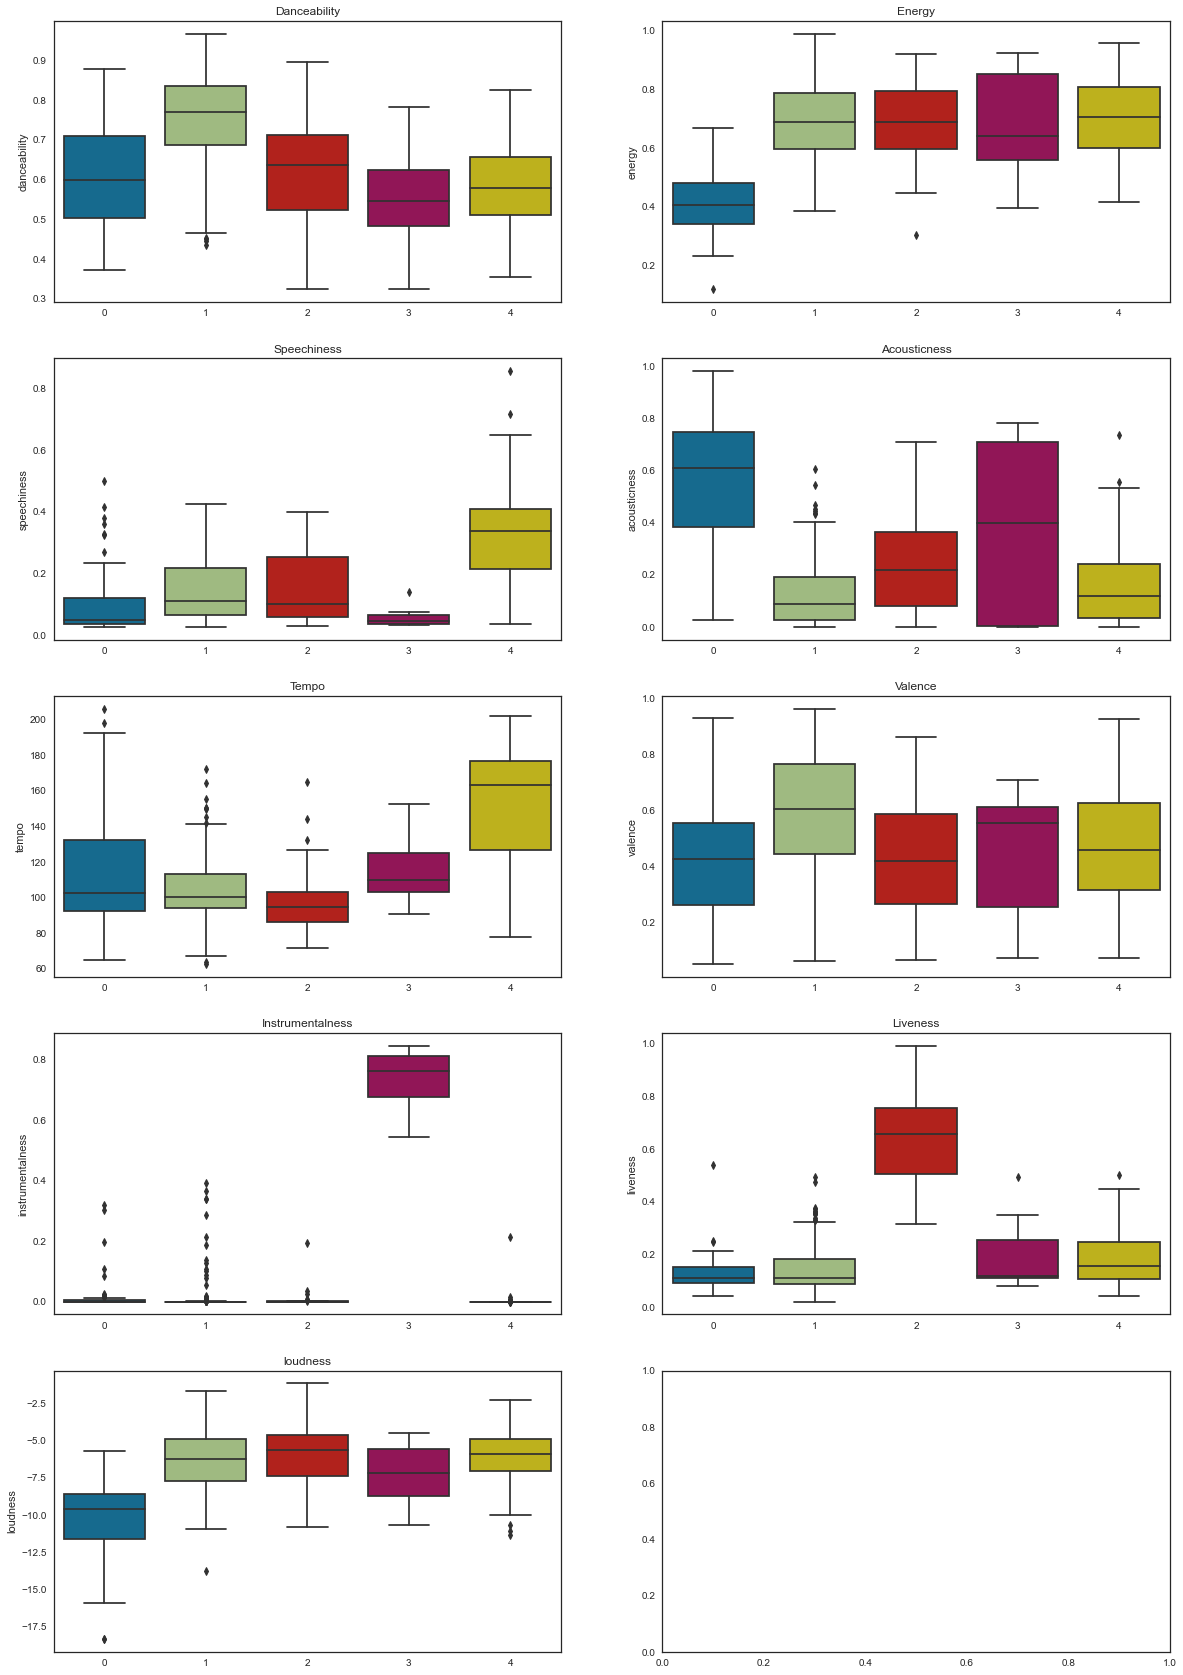

In [82]:
## Set layout of subplots
fig, ax = plt.subplots(5, 2, figsize=(20, 30))


ax[0,0].title.set_text('Danceability')
sns.boxplot(x = df_final['Cluster'], y = df_final['danceability'], ax = ax[0,0]).set(xlabel=None)

ax[0,1].title.set_text('Energy')
sns.boxplot(x = df_final['Cluster'], y = df_final['energy'], ax = ax[0,1]).set(xlabel=None)

ax[1,0].title.set_text('Speechiness')
sns.boxplot(x = df_final['Cluster'], y = df_final['speechiness'], ax = ax[1,0]).set(xlabel=None)

ax[1,1].title.set_text('Acousticness')
sns.boxplot(x = df_final['Cluster'], y = df_final['acousticness'], ax = ax[1,1]).set(xlabel=None)

ax[2,0].title.set_text('Tempo')
sns.boxplot(x = df_final['Cluster'], y = df_final['tempo'], ax = ax[2,0]).set(xlabel=None)

ax[2,1].title.set_text('Valence')
sns.boxplot(x = df_final['Cluster'], y = df_final['valence'], ax = ax[2,1]).set(xlabel=None)

ax[3,0].title.set_text('Instrumentalness')
sns.boxplot(x = df_final['Cluster'], y = df_final['instrumentalness'], ax = ax[3,0]).set(xlabel=None)

ax[3,1].title.set_text('Liveness')
sns.boxplot(x = df_final['Cluster'], y = df_final['liveness'], ax = ax[3,1]).set(xlabel=None)

ax[4,0].title.set_text('loudness')
sns.boxplot(x = df_final['Cluster'], y = df_final['loudness'], ax = ax[4,0]).set(xlabel=None)


Viewing the dataframe with conditional formatting, on the other hand, 

In [15]:
## Create a dataframe with the average value of each feature per each cluster
df_review = pd.DataFrame(index = df_final['Cluster'].unique(), columns = df_scaled_features.columns).sort_index()

## Iterate through features (columns) and clusters (index)
for col in df_review.columns:    
    for i in df_review.index:
        
        ## Assign avg value into appropriate cell
        df_review.loc[i, col] = df_final.loc[df_final['Cluster'] == i, col].mean()
        
## Change data format to numeric        
df_review = df_review.astype(float)

## Apply conditional formatting to the dataframe
df_review.style.background_gradient(axis = 0, cmap="Blues")
# df_review.style.background_gradient(axis = 0, cmap="coolwarm")

,danceability,tempo,energy,speechiness,loudness,liveness,acousticness,instrumentalness,valence
0,0.601870,113.260722,0.408093,0.104844,-10.320296,0.130228,0.564904,0.021609,0.428972
1,0.750563,104.775095,0.690905,0.145255,-6.290479,0.147096,0.127732,0.015478,0.597794
2,0.613706,98.434676,0.693706,0.150138,-6.048588,0.649882,0.242337,0.008295,0.437356
3,0.552875,115.776500,0.670375,0.059025,-7.282500,0.200800,0.377418,0.735375,0.458450
4,0.585609,150.522768,0.697101,0.319783,-6.087217,0.189897,0.157333,0.003689,0.471203


0  Calm (Low energy); quieter; more acoustic
1  Danceable; high energy; loud; happier/positive vibe; not live, acoustic, or instrumental
2  Loud, live, energetic; slower-paced
3  Instumental, less wordy, not danceable
4  More "speechy"; faster paced


In [148]:
cluster_0 = [r['Song Title'] + " | " + r['Main Artist'] for i, r in df_final[df_final['Cluster'] == 0].iterrows()]
cluster_1 = [r['Song Title'] + " | " + r['Main Artist'] for i, r in df_final[df_final['Cluster'] == 1].iterrows()]
cluster_2 = [r['Song Title'] + " | " + r['Main Artist'] for i, r in df_final[df_final['Cluster'] == 2].iterrows()]
cluster_3 = [r['Song Title'] + " | " + r['Main Artist'] for i, r in df_final[df_final['Cluster'] == 3].iterrows()]


df_cluster_results = pd.concat([pd.DataFrame(cluster_0), pd.DataFrame(cluster_1), pd.DataFrame(cluster_2),
                                pd.DataFrame(cluster_3),], ignore_index = True, axis = 1)

## Fill extra rows in shorter columns with empty space
df_cluster_results.fillna('', inplace = True)

df_cluster_results

,0,1,2,3
0,Redbone | Childish Gambino,Dang! (feat. Anderson .Paak) | Mac Miller,Crooked Smile (feat. TLC) | J. Cole,Sunset Lover | Petit Biscuit
1,Controlla | Drake,Don't Wanna Fight | Alabama Shakes,Waves | Kanye West,Always Alright | Alabama Shakes
2,Blessings (feat. Jamila Woods) | Chance the Ra...,Get It Together | Drake,Rosa Parks | Outkast,Around The World | Kings of Leon
3,Passionfruit | Drake,Definition | Black Star,Gimme All Your Love | Alabama Shakes,Waste A Moment | Kings of Leon
4,Down | Marian Hill,HUMBLE. | Kendrick Lamar,Ignorance Is Bliss | Kendrick Lamar,Whipping Post | Allman Brothers Band
...,...,...,...,...
185,,Brokedown- Parts 1 and 2 | The California Hone...,,
186,,Do I Wanna Know? | Arctic Monkeys,,
187,,Part of Me | Tedeschi Trucks Band,,
188,,GotItBad | St. Paul & The Broken Bones,,


___
## PCA

In [140]:
## We'll use 2 components for plotting purposes (x, y axis)
pca = PCA(n_components = 2)

## Apply PC instances to the scaled features.  Create a dataframe 
df_princ_comp = pd.DataFrame(pca.fit_transform(df_scaled_features), columns = ['PC 1', 'PC 2'])


## Add Cluster labels back in 
df_princ_comp = df_princ_comp.join(df_final['Cluster'])

## Display the amount of varia
print('PC 1:', round(pca.explained_variance_ratio_[0], 3), '| PC 2:', round(pca.explained_variance_ratio_[1], 3))
print(round(pca.explained_variance_ratio_.sum(), 3))

df_princ_comp.head()

PC 1: 0.246 | PC 2: 0.156
0.402


,PC 1,PC 2,Cluster
0,-0.654703,-0.981582,1
1,3.514070,-0.806563,3
2,-1.435387,0.102600,1
3,1.665321,-0.298940,0
4,0.135888,-1.652232,1


<AxesSubplot:>

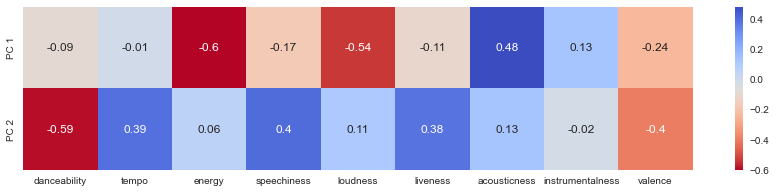

In [142]:
#### Use heatmap with values in cellls

## Set size of plot
plt.figure(figsize = (15, 3))

pca_comp_vals = pd.DataFrame(pca.components_.T, columns = ['PC 1', 'PC 2'], index = df_scaled_features.columns)

sns.heatmap(round(pca_comp_vals, 2).T, annot=True, cmap='coolwarm_r')

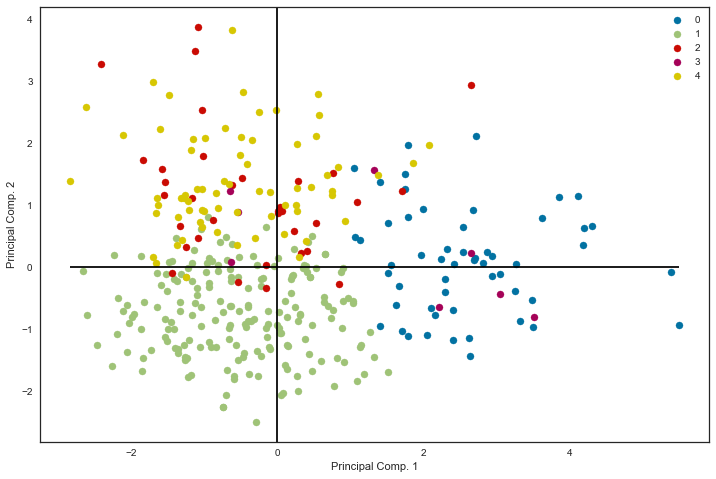

In [143]:
## Set size of plot
plt.figure(figsize = (12, 8))


# colors = ['r', 'g', 'b']
# for target, color in zip(targets,colors):
for cluster in np.arange(0,k):
    
    plt.scatter(df_princ_comp[df_princ_comp['Cluster'] == cluster]['PC 1'],
               df_princ_comp[df_princ_comp['Cluster'] == cluster]['PC 2'], s = 50, label = cluster)

## Plot lines at x = 0 & y = 0 to help distinguish between PCs    
plt.axvline(x = 0, color = 'black')
plt.hlines(y=0, xmin = df_princ_comp['PC 1'].min(), xmax = df_princ_comp['PC 1'].max(), color = 'black')

plt.xlabel('Principal Comp. 1')
plt.ylabel('Principal Comp. 2')
plt.legend()
# ax.grid()

# ---------------------------------------------------------------------------------------------------------
# Conclusions

# Next Steps